In [1]:
import samplerate
from tensorflow import keras
from keras import losses
from keras.callbacks import EarlyStopping
from keras.optimizers import adam
from sklearn.utils import class_weight
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import numpy as np
import os
import sys
from numpy import array, hstack
import statsmodels.api as sm 
os.environ["CUDA_VISIBLE_DEVICES"]="2"
sys.path.insert(1,'/home/jgozlan/GIT/scripts/')


import tensorflow as tf
tf.test.is_gpu_available()


from imu_extractor import get_all_dataframes_for_classification, get_freq_magn, transform_dataset_into_freq_magn
from train_test_split_multi import get_train_test_split
from baseline import find_frequency,repeat_period_forecast_acf, get_mean_line_forecast, get_flat_line_forecast, repeat_period_forecast_acf
from models import create_simple_classifier_time, create_simple_classifier_frequency

Using TensorFlow backend.


In [3]:
path_classes = ['Run_Features', 'Walk_Features','CarDriving_Features',
               'Karting_Features','Hiking_Features','MotorcycleHelmet_Features',
               'Scooter_Features','SkateboardChesty_Features','SnowboardSeeker_Features']

# define cluster classes
classes_values = [0, 0, 1, 2, 3, 3, 3, 3, 3]

number_class = 4

recording_freq = 6400.0
downsampling_freq = 200.0

all_dfs_classes = []

for i,c in enumerate(path_classes):
    print(c)
    dfs= get_all_dataframes_for_classification('Database/' + c, recording_freq, downsampling_freq, classes_values[i])
    all_dfs_classes.append(dfs)
    
all_df = [item for sublist in all_dfs_classes for item in sublist]

Run_Features
GH010029.MP4.eis_dump.bin_features.json
GH010011.MP4.eis_dump.bin_features.json
GH019983.MP4.eis_dump.bin_features.json
GH010019.MP4.eis_dump.bin_features.json
GH010030.MP4.eis_dump.bin_features.json
GH010028.MP4.eis_dump.bin_features.json
GH019982.MP4.eis_dump.bin_features.json
GH010012.MP4.eis_dump.bin_features.json
GH019973.MP4.eis_dump.bin_features.json
Walk_Features
GH010018.MP4.eis_dump.bin_features.json
GH019969.MP4.eis_dump.bin_features.json
GH010034.MP4.eis_dump.bin_features.json
GH010014.MP4.eis_dump.bin_features.json
GH019975.MP4.eis_dump.bin_features.json
GH010004.MP4.eis_dump.bin_features.json
GH010005.MP4.eis_dump.bin_features.json
GH010019.MP4.eis_dump.bin_features.json
GH019968.MP4.eis_dump.bin_features.json
GH010035.MP4.eis_dump.bin_features.json
GH019976.MP4.eis_dump.bin_features.json
GH010013.MP4.eis_dump.bin_features.json
GH019980.MP4.eis_dump.bin_features.json
GH010012.MP4.eis_dump.bin_features.json
CarDriving_Features
GX010006.MP4.eis_dump.bin_feature

In [4]:
lag = 500
ahead = 100
delay = 5
test_size = 0.2
dim = 13


classification = True
target_index = dim - 1

X_train, y_train, X_test, y_test = get_train_test_split(all_df, test_size, lag, ahead, delay, target_index, classification)

y_train_cat =  keras.utils.to_categorical(y_train)
y_test_cat =  keras.utils.to_categorical(y_test)

# compute class weights for balanced training

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [7]:
# get acf version of each sample
def get_acf_for_gyro(X_inputs):
    
    X_acf = np.zeros((X_inputs.shape[0],X_inputs.shape[1],3))

    for i,input in enumerate(X_inputs):

        if i%10000 == 0:
            print(i)
        x_gyro = input[:,0]
        y_gyro = input[:,1]
        z_gyro = input[:,2]
        acf_x = sm.tsa.acf(x_gyro, nlags = lag) 
        acf_y = sm.tsa.acf(y_gyro, nlags = lag) 
        acf_z = sm.tsa.acf(z_gyro, nlags = lag) 
        X_acf[i][:,0] = acf_x
        X_acf[i][:,1] = acf_y
        X_acf[i][:,2] = acf_z

    return X_acf

X_train_acf = get_acf_for_gyro(X_train)
X_test_acf =  get_acf_for_gyro(X_test)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


In [19]:
# create model for time domain representation (acf), we go from 12 to 3 (only the three gyroscope axis)
acf_dim =3
model1 = create_simple_classifier_time(number_class= number_class, lag = lag, in_dim = acf_dim)
model1.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

batch_size = 200
verbose = 1
epochs = 20

model1.fit(X_train_acf, y_train_cat, 
          epochs=epochs, shuffle =True, batch_size = batch_size, 
          verbose=verbose, 
          class_weight = class_weights, 
          validation_data=(X_test_acf, y_test_cat))


Train on 207579 samples, validate on 46325 samples
Epoch 1/20
207579/207579 [==============================] - 14s 68us/step - loss: 0.0603 - accuracy: 0.9800 - val_loss: 0.0750 - val_accuracy: 0.9820
Epoch 2/20
207579/207579 [==============================] - 12s 57us/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0673 - val_accuracy: 0.9808
Epoch 3/20
207579/207579 [==============================] - 12s 57us/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0772 - val_accuracy: 0.9815
Epoch 4/20
207579/207579 [==============================] - 12s 56us/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0765 - val_accuracy: 0.9823
Epoch 5/20
207579/207579 [==============================] - 12s 57us/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0951 - val_accuracy: 0.9816
Epoch 6/20
121400/207579 [================>.............] - ETA: 4s - loss: 0.0035 - accuracy: 0.9989

KeyboardInterrupt: 

In [5]:
# get frequneyc domain representation
num_freq = 12

# 6 first axes (gyro + accelerometer (usually enough))
transformed_X_train = transform_dataset_into_freq_magn(X_train[:,:,:6], downsampling_freq, num_freq)
transformed_X_test = transform_dataset_into_freq_magn(X_test[:,:,:6], downsampling_freq, num_freq)

freq_dim_in = transformed_X_train.shape[1]

In [7]:
# create and train freauency domain representation
model2 = create_simple_classifier_frequency(number_class = number_class, in_dim = freq_dim_in)
model2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

batch_size = 200
verbose = 1
epochs = 20

model2.fit(transformed_X_train, y_train_cat, 
          epochs=epochs, shuffle =True, batch_size = batch_size, 
          verbose=verbose, 
          class_weight = class_weights, 
          validation_data=(transformed_X_test, y_test_cat))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 207571 samples, validate on 46325 samples
Epoch 1/20
207571/207571 [==============================] - 5s 23us/step - loss: 0.3037 - accuracy: 0.9214 - val_loss: 0.0839 - val_accuracy: 0.9736
Epoch 2/20
207571/207571 [==============================] - 5s 22us/step - loss: 0.0905 - accuracy: 0.9711 - val_loss: 0.0654 - val_accuracy: 0.9798
Epoch 3/20
207571/207571 [==============================] - 4s 21us/step - loss: 0.0668 - accuracy: 0.9788 - val_loss: 0.0593 - val_accuracy: 0.9808
Epoch 4/20
207571/207571 [==============================] - 4s 21us/step - loss: 0.0553 - accuracy: 0.9820 - val_loss: 0.0527 - val_accuracy: 0.9817
Epoch 5/20
207571/207571 [==============================] - 4s 21us/step - loss: 0.0477 - accuracy: 0.9843 - val_loss: 0.0687 - val_accuracy: 0.9773
Epoch 6/20
207571/207571 [==============================] - 4s 21us/step - loss: 0.0395 - accuracy: 0.9870 - val_loss: 0.0

In [8]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                5800      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 164       
Total params: 5,964
Trainable params: 5,964
Non-trainable params: 0
_________________________________________________________________


In [9]:
# CLUSTERING
# goal is to find similarities betweeen clusters
from sklearn.cluster import MeanShift
from numpy import unique
from numpy import where
from matplotlib import pyplot
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pickle


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

classes = ["Run-Walk", "Car", "Karting","Others"]

cmap = cm.get_cmap('viridis', len(classes))
print(cmap)

n = 20000  # for 2 random indices
#index = np.random.choice(transformed_X_train.shape[0], n, replace=False)  
index = np.random.choice(X_train_acf.shape[0], n, replace=False)  
x_random = X_train_acf[index]
#x_random = X_train[index][:,:,[0,1,2,]]
y_random = y_train[index]


In [10]:
x_random = x_random.reshape((-1,x_random.shape[1]*x_random.shape[2]))

In [11]:
x_random.shape

(20000, 1500)

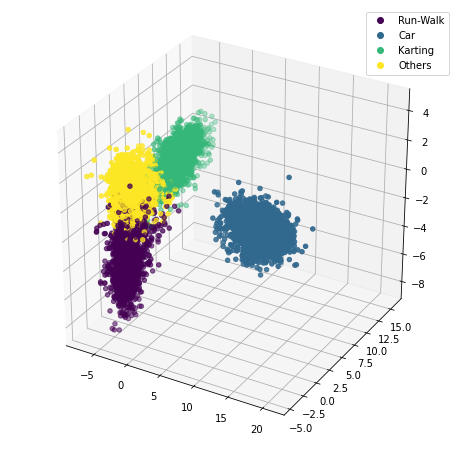

In [12]:

lda_model = LDA(n_components=3).fit(x_random, y_random)

X_random_lda3 = lda_model.transform(x_random)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(X_random_lda3[:,0], X_random_lda3[:,1], X_random_lda3[:,2], c= y_random, label = y_random)
ax.legend(handles=scat.legend_elements()[0], labels=classes)


In [28]:
filename = 'lda_model_freq6.sav'
pickle.dump(lda_model, open(filename, 'wb'))


[0 1 2 3]


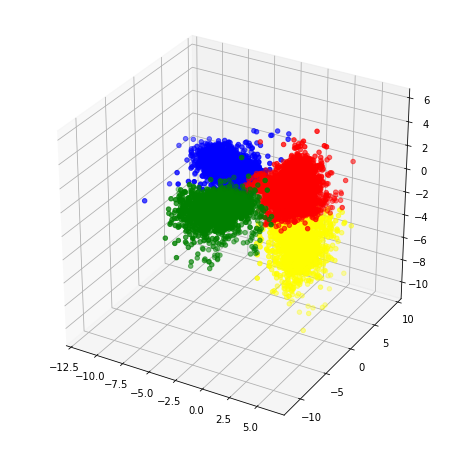

In [29]:
from sklearn.cluster import KMeans

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
#ax = fig.add_subplot(projection='3d')
#ax = fig.add_subplot()
# fit model and predict clusters

kmeans = KMeans(n_clusters=4, random_state=0).fit(X_random_lda3)
yhat = kmeans.predict(X_random_lda3)

clusters = unique(yhat)
print(clusters)
colors = ['red','green','blue','yellow']
# create scatter plot for samples from each cluster
for i,cluster in enumerate(clusters):
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    #ax.scatter(X_random_lda3[row_ix, 0], X_random_lda3[row_ix, 1], X_random_lda3[row_ix,2])
    ax.scatter(X_random_lda3[row_ix, 0], X_random_lda3[row_ix, 1], X_random_lda3[row_ix,2],color = colors[i])
# show the plot
plt.show()

In [10]:
kmeans.cluster_centers_

array([[ 2.17731026,  0.16354772,  0.14950638],
       [-0.36351173, -0.14540346,  0.31409745],
       [-0.87385749,  3.32270468, -0.0852783 ],
       [-0.10210628, -0.36158332, -1.48453031]])

In [30]:
filename = 'kmeans_model_freq6.sav'
pickle.dump(kmeans, open(filename, 'wb'))


[[ 1.87149012  0.40509654  0.75106284]
 [-2.44721039 -5.26931796 -0.05332124]
 [-5.20863489  2.46314981 -0.06374572]
 [ 2.29802465  0.49936363 -3.58151163]]


[ 0  1  2  3  4  5  6  7  8  9 10 11]


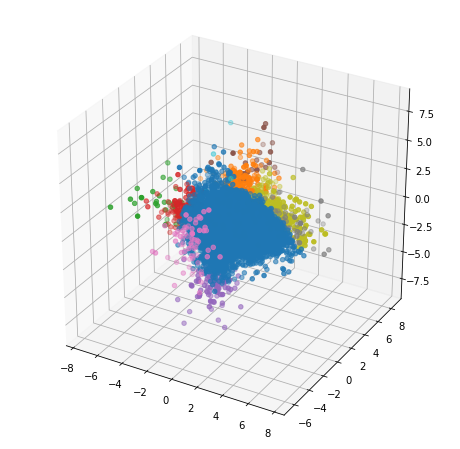

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

model = MeanShift()
# fit model and predict clusters

yhat = model.fit_predict(X_random_lda3)

clusters = unique(yhat)
print(clusters)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    ax.scatter(X_random_lda3[row_ix, 0], X_random_lda3[row_ix, 1], X_random_lda3[row_ix,2])
# show the plot
plt.show()

[0 1 2 3]


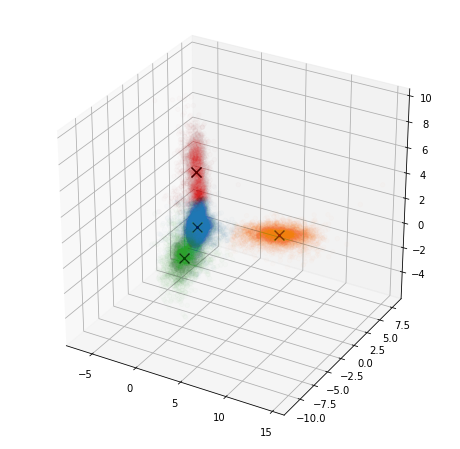

In [67]:
from sklearn.cluster import KMeans

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
#ax = fig.add_subplot(projection='3d')
#ax = fig.add_subplot()
# fit model and predict clusters

kmeans = KMeans(n_clusters=4, random_state=0).fit(X_random_lda3)
yhat = kmeans.predict(X_random_lda3)

clusters = unique(yhat)
print(clusters)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    #ax.scatter(X_random_lda3[row_ix, 0], X_random_lda3[row_ix, 1], X_random_lda3[row_ix,2])
    ax.scatter(X_random_lda3[row_ix, 0], X_random_lda3[row_ix, 1], X_random_lda3[row_ix,2], alpha = 0.01)
    ax.scatter(kmeans.cluster_centers_[cluster][0],kmeans.cluster_centers_[cluster][1],kmeans.cluster_centers_[cluster][2], color = 'black', marker="x", s= 100)
# show the plot
plt.show()

[0 1 2]


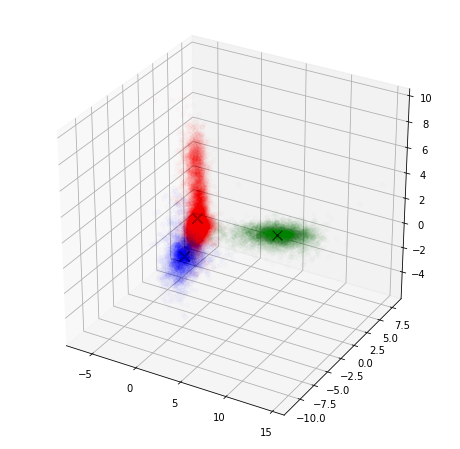

In [71]:
from sklearn.mixture import GaussianMixture

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

gaussian_model= GaussianMixture(n_components=3, random_state=0).fit(X_random_lda3)
yhat = gaussian_model.predict(X_random_lda3)
clusters = unique(yhat)
print(clusters)
colors = ["red","green","blue"]
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    ax.scatter(X_random_lda3[row_ix, 0], X_random_lda3[row_ix, 1], X_random_lda3[row_ix,2], color = colors[cluster],alpha = 0.01)
    ax.scatter(gaussian_model.means_[cluster][0],gaussian_model.means_[cluster][1],gaussian_model.means_[cluster][2], color = 'black', marker="x", s= 100)

# show the plot
plt.show()

In [70]:
filename = 'gmm_model.sav'
pickle.dump(gaussian_model, open(filename, 'wb'))

In [51]:
gaussian_model.means_

array([[-2.04179223e+00,  8.76441153e-01, -2.02705341e-02],
       [ 6.53692098e+00,  1.65055621e+00,  3.85511953e-03],
       [ 8.55922211e-01, -5.81223900e+00,  8.30766086e-02]])